# Selective SSM

Authors: Chase T. Grajeda, Stefan T. Radev

### Imports

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
import numpy as np
import pickle as pkl

import bayesflow as bf

from mamba import MambaSSM

/home/space/anaconda3/envs/mambapower/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
with torch.enable_grad():
in custom training loops.


### Verify GPU is accessible

### Verify Keras sees GPU

### Test pass on Mamba

In [2]:
mamba = MambaSSM(summary_dim=16)

In [3]:
simulator = bf.simulators.LotkaVolterra(subsample=None, flatten=False, dt=0.01)

### Test Model

In [4]:
samples = simulator.sample(5)
print([key for key in samples.keys()])
print("Parameter Shape:", samples["parameters"].shape)
print("Observable Shape:", samples["observables"].shape)

['parameters', 'observables']
Parameter Shape: (5, 4)
Observable Shape: (5, 100, 2)


In [5]:
adapter = (
	bf.adapters.Adapter()
	.convert_dtype("float64", "float32")
	.as_time_series("observables")
	.log("observables", p1=True)
	.rename("parameters", "inference_variables")
	.rename("observables", "summary_variables")
)

inference_net = bf.networks.CouplingFlow()

workflow = bf.BasicWorkflow(
	simulator=simulator,
	adapter=adapter,
	inference_network=inference_net,
	summary_network=mamba,
    inference_variables=["parameters"]
)

In [6]:
train_data = simulator.sample(10000)
test_data = simulator.sample(200)

In [7]:
history = workflow.fit_offline(train_data, epochs=100, batch_size=64, validation_data=test_data)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: -2.7376 - loss/inference_loss: -2.7376 - val_loss: -5.0575 - val_loss/inference_loss: -5.0575
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: -5.5113 - loss/inference_loss: -5.5113 - val_loss: -7.0164 - val_loss/inference_loss: -7.0164
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: -7.0745 - loss/inference_loss: -7.0745 - val_loss: -7.2122 - val_loss/inference_loss: -7.2122
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: -6.8179 - loss/inference_loss: -6.8179 - val_loss: -5.8391 - val_loss/inference_loss: -5.8391
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: -6.8157 - loss/inference_loss: -6.8157 - val_loss: -8.1670 - val_loss/inference_loss: -8.1670
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: -6.8103 - loss/inference_loss: -6.8103 - val_loss: -7.6139 - val_loss/inference_loss: -7.6139
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: -7

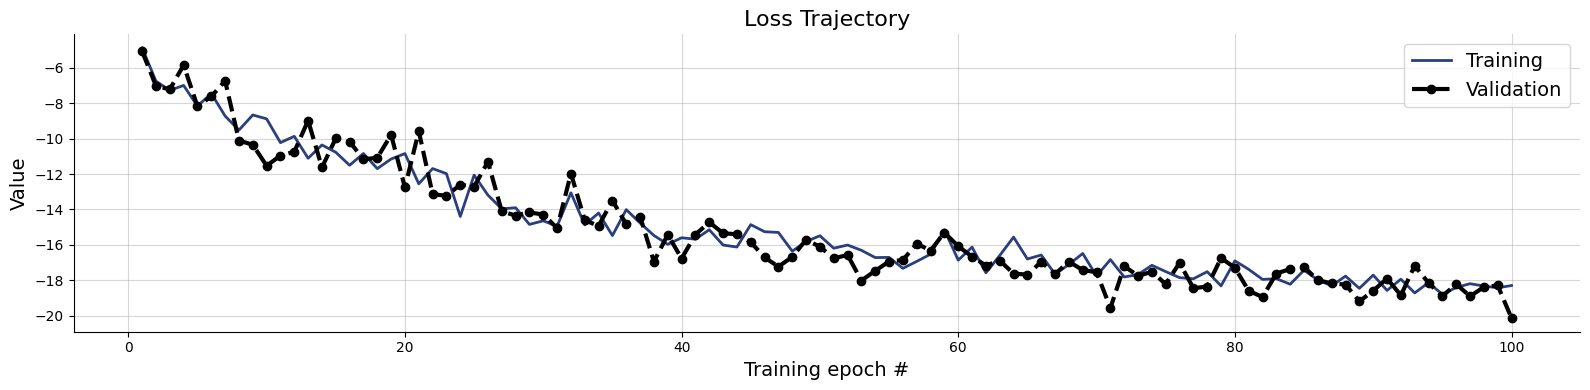

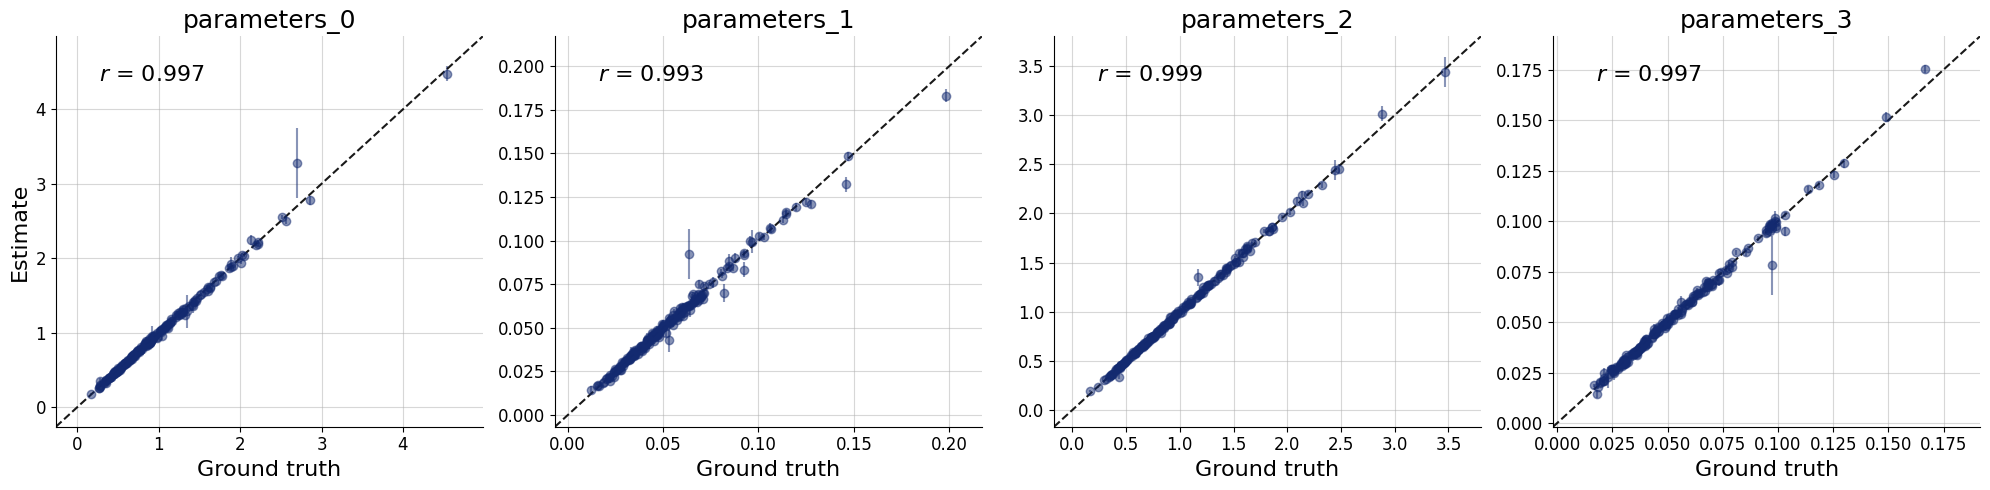

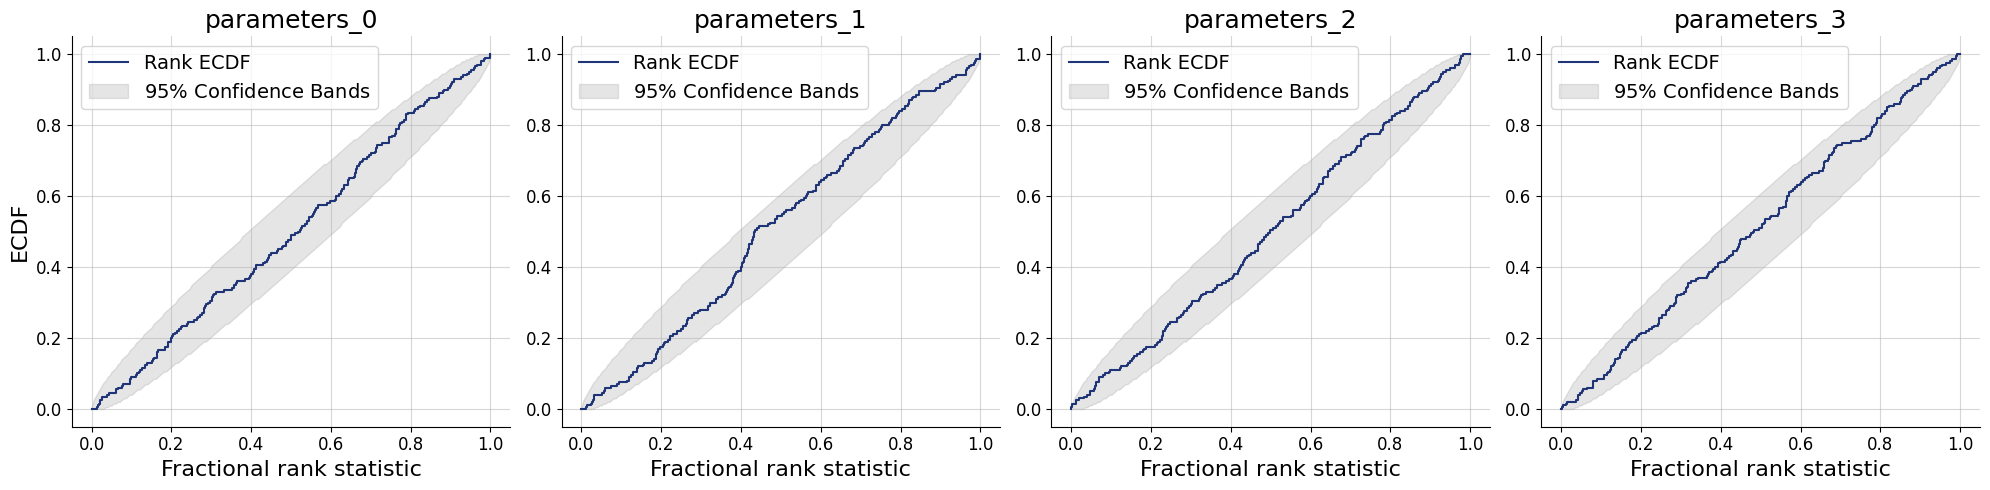

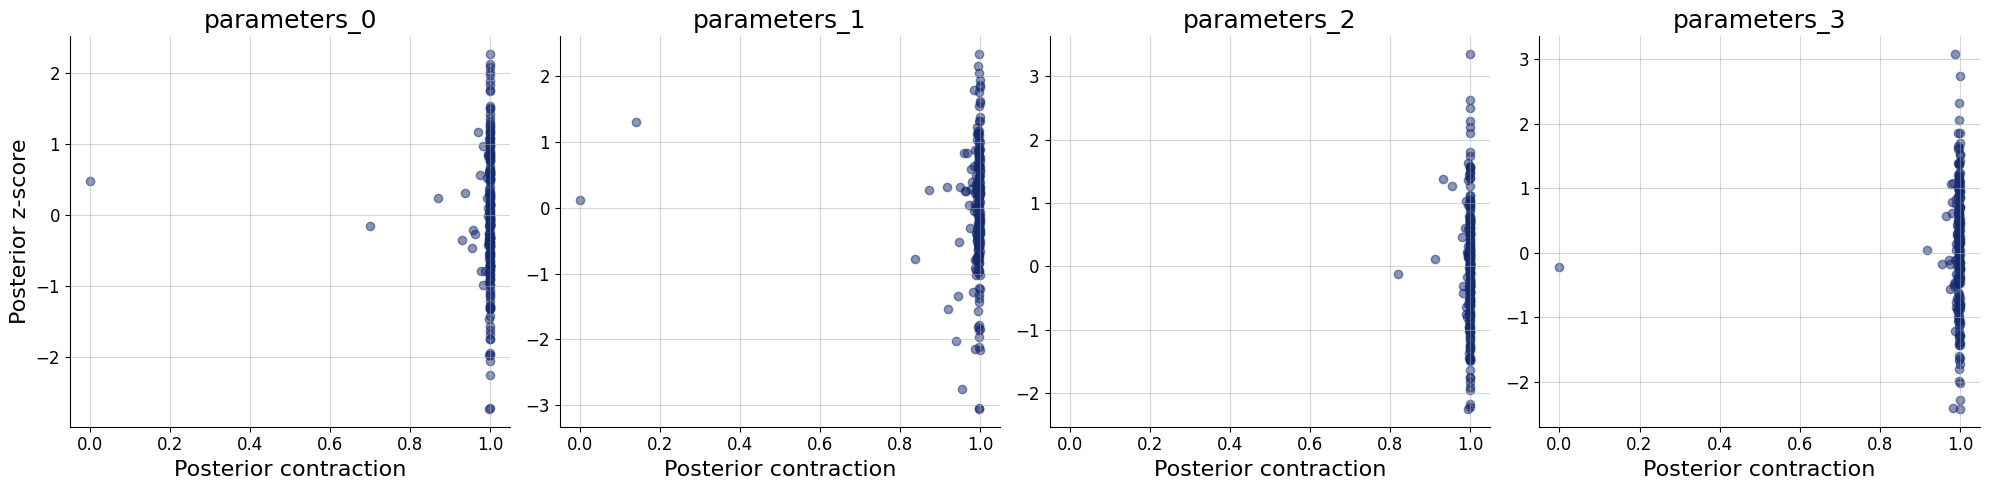

In [8]:
figs = workflow.plot_default_diagnostics(test_data=test_data)

In [9]:
workflow.approximator.summary()

Model: "continuous_approximator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ coupling_flow (CouplingFlow)    │ ?                      │       233,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mamba_ssm (MambaSSM)            │ ?                      │        68,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 905,473 (3.45 MB)

 Trainable params: 301,808 (1.15 MB)

 Non-trainable params: 48 (192.00 B)

 Optimizer params: 603,617 (2.30 MB)